In [24]:
import numpy as np 
import pandas as pd 
import os
# import matplotlib.pyplot as plt 
# import seaborn as sns 
# # from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# import plotly.express as px
# from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
# from nltk.stem import WordNetLemmatizer
import spacy

import ru_core_news_md
nlp = ru_core_news_md.load()


tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
# lemm = WordNetLemmatizer()
# init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GlebV\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Classification: Using Transformers Encoder Block
- A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data
- They hold the potential to understand the relationshipbetween sequential elements that are far from each other
- They are way more accurate 
- They pay equal attention to all the elements in the sequence

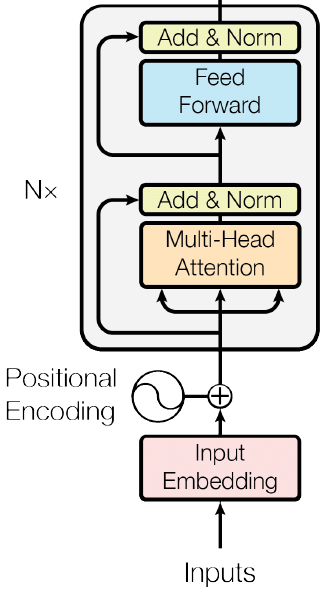

In [6]:
# data1 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)
data2 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [9]:
# data1 = data1[['headline','is_sarcastic']]
data = data2[['headline','is_sarcastic']]

# data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)

In [10]:
data

headline  is_sarcastic
0      former versace store clerk sues over secret 'b...             0
1      the 'roseanne' revival catches up to our thorn...             0
2      mom starting to fear son's web series closest ...             1
3      boehner just wants wife to listen, not come up...             1
4      j.k. rowling wishes snape happy birthday in th...             0
...                                                  ...           ...
26704               american politics in moral free-fall             0
26705                            america's best 20 hikes             0
26706                              reparations and obama             0
26707  israeli ban targeting boycott supporters raise...             0
26708                  gourmet gifts for the foodie 2014             0

[26709 rows x 2 columns]

# EDA and Text Preprocessing

## Checking for Missing Values

In [11]:
data.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

## Finding the Classes Balance/Imbalance

In [12]:
px.bar(data.groupby('is_sarcastic').count().reset_index(), x='headline',title='Count of Sarcastic and Genuine Headlines')

NameError: name 'px' is not defined

## Special Characters Removal
- We will not remove numbers from the text data right away, lets further analyse if they contain any relevant information
- We can find the entity type of the tokens in the sentences using Named Entity Recognition (NER), this will help us identify the type and relevance of numbers in our text data

In [13]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):
    
    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

In [25]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|███████████████████████████████████████████████████████████████████████████| 26709/26709 [01:38<00:00, 270.04it/s]


In [26]:
data['clean_headline'] = data['headline'].apply(text_cleaning)

In [27]:
data['sentence_length'] = data['clean_headline'].apply(lambda x: len(x.split()))
data

headline  is_sarcastic  \
0      former versace store clerk sues over secret 'b...             0   
1      the 'roseanne' revival catches up to our thorn...             0   
2      mom starting to fear son's web series closest ...             1   
3      boehner just wants wife to listen, not come up...             1   
4      j.k. rowling wishes snape happy birthday in th...             0   
...                                                  ...           ...   
26704               american politics in moral free-fall             0   
26705                            america's best 20 hikes             0   
26706                              reparations and obama             0   
26707  israeli ban targeting boycott supporters raise...             0   
26708                  gourmet gifts for the foodie 2014             0   

             entity                                     clean_headline  \
0                    former versace store clerk sue secret black co...   
1                    roseanne revival catch thorny political mood b...   
2                    mom start fear son web series closest thing gr...   
3                    boehner want wife listen not come alternative ...   
4            PERSON  j k rowling wish snape happy birthday magical way   
...             ...                                                ...   
26704          NORP                  american politics moral free fall   
26705  GPE,CARDINAL                               america best 20 hike   
26706                                                reparations obama   
26707          NORP  israeli ban target boycott supporters raise al...   
26708          DATE                           gourmet gift foodie 2014   

       sentence_length  contains_number  
0                   10            False  
1                    8            False  
2                    9            False  
3                   10            False  
4                    9            False  
...                ...              ...  
26704                5            False  
26705                4             True  
26706                2            False  
26707                8            False  
26708                4             True  

[26709 rows x 6 columns]

## Headlines Length Distribution
- Look for outlier length of headline sentences
- Usually the headlines shouldn't be more than 20-30 words

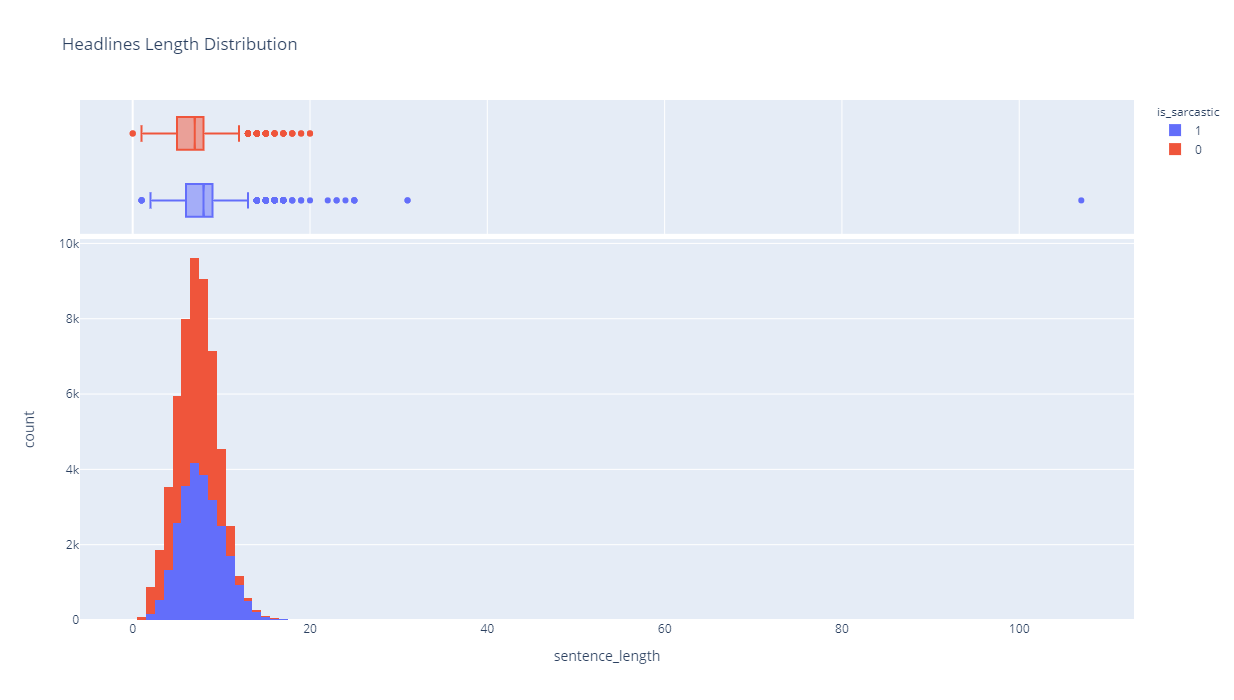

In [60]:
px.histogram(data, x="sentence_length",height=700, color='is_sarcastic', title="Headlines Length Distribution", marginal="box")

In [28]:
data[data['sentence_length']==107]['headline']

Series([], Name: headline, dtype: object)

In [29]:
data.drop(data[data['sentence_length'] == 107].index, inplace = True)
data.reset_index(inplace=True, drop=True)

## Headlines Length Distribution: Outliers Removed
- The headlines after the removal of outliers do not exceed the limit of 20-30 words
- They are mostly centered in the range of 5-10 words

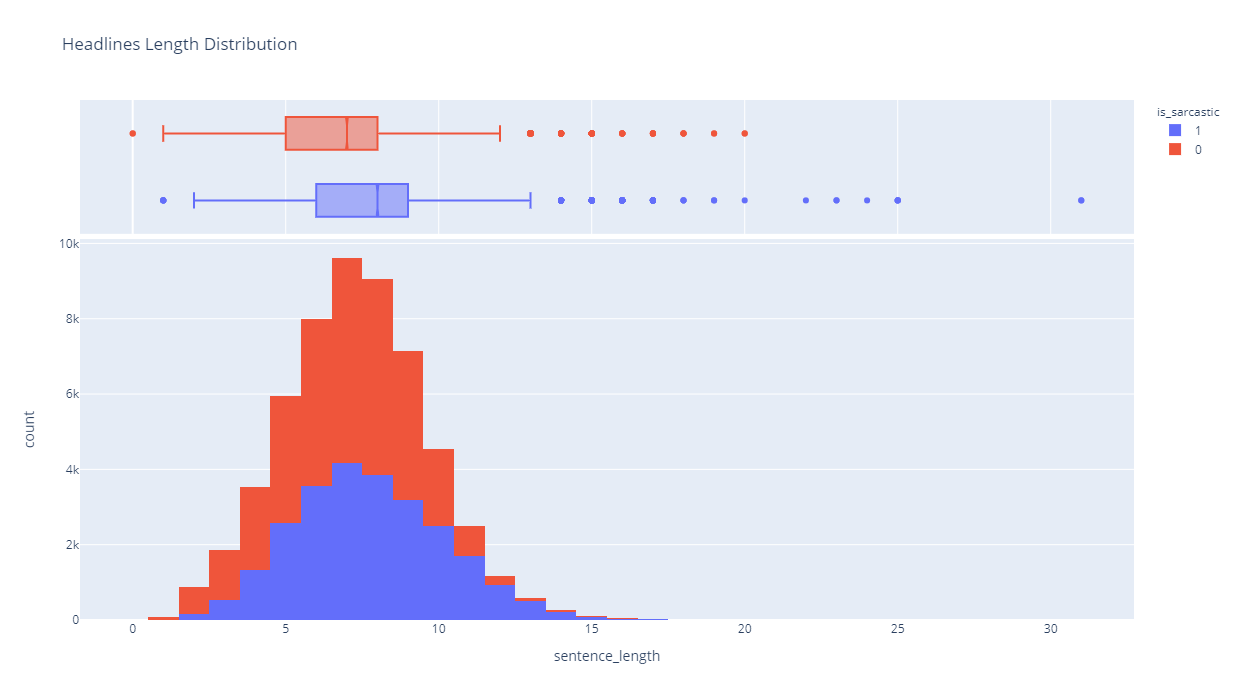

In [63]:
px.histogram(data, x="sentence_length",height=700, color='is_sarcastic', title="Headlines Length Distribution", marginal="box")

## Filtering: Find Sentences that Contain Numbers

In [30]:
data['contains_number'] = data['clean_headline'].apply(lambda x: bool(re.search(r'\d+', x)))
data

headline  is_sarcastic  \
0      former versace store clerk sues over secret 'b...             0   
1      the 'roseanne' revival catches up to our thorn...             0   
2      mom starting to fear son's web series closest ...             1   
3      boehner just wants wife to listen, not come up...             1   
4      j.k. rowling wishes snape happy birthday in th...             0   
...                                                  ...           ...   
26704               american politics in moral free-fall             0   
26705                            america's best 20 hikes             0   
26706                              reparations and obama             0   
26707  israeli ban targeting boycott supporters raise...             0   
26708                  gourmet gifts for the foodie 2014             0   

             entity                                     clean_headline  \
0                    former versace store clerk sue secret black co...   
1                    roseanne revival catch thorny political mood b...   
2                    mom start fear son web series closest thing gr...   
3                    boehner want wife listen not come alternative ...   
4            PERSON  j k rowling wish snape happy birthday magical way   
...             ...                                                ...   
26704          NORP                  american politics moral free fall   
26705  GPE,CARDINAL                               america best 20 hike   
26706                                                reparations obama   
26707          NORP  israeli ban target boycott supporters raise al...   
26708          DATE                           gourmet gift foodie 2014   

       sentence_length  contains_number  
0                   10            False  
1                    8            False  
2                    9            False  
3                   10            False  
4                    9            False  
...                ...              ...  
26704                5            False  
26705                4             True  
26706                2            False  
26707                8            False  
26708                4             True  

[26709 rows x 6 columns]

### Analysis of Samples Containing numbers of Time, Date or Cardinal Entity type
- The numbers in a text data can have different implications
- While the naive text preprocessing methods suggest that the numbers should be removed along with the special characters
- The entity type of these numbers should be identified to get their exact implications

### 10 Random Samples: Date Entity 

In [31]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='DATE')].sample(10)

headline  is_sarcastic entity  \
11151               class of 2014, we've come a long way             0   DATE   
22397       how i navigated my first 7 years of sobriety             0   DATE   
24310             is 2017 set up for a financial crisis?             0   DATE   
6521          the best style moments from wimbledon 2015             0   DATE   
21335                   news roundup for august 17, 2017             0   DATE   
23218                    news roundup for august 2, 2017             0   DATE   
13930       '97 camaros to come with pubescent mustaches             1   DATE   
5227                    news roundup for august 23, 2017             0   DATE   
17489  this 23-month-old is probably more stylish tha...             0   DATE   
18061              love your skin in your 50s and beyond             0   DATE   

                            clean_headline  sentence_length  contains_number  
11151             class 2014 come long way                5             True  
22397      navigate first 7 years sobriety                5             True  
24310            2017 set financial crisis                4             True  
6521     best style moments wimbledon 2015                5             True  
21335          news roundup august 17 2017                5             True  
23218           news roundup august 2 2017                5             True  
13930  97 camaros come pubescent mustaches                5             True  
5227           news roundup august 23 2017                5             True  
17489        23 month old probably stylish                5             True  
18061                 love skin 50s beyond                4             True

### 10 Random Samples: Time Entity

In [32]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='TIME')].sample(10)

headline  is_sarcastic entity  \
18810                   5-minute hairstyles -- for real!             0   TIME   
22033         the 1 minute blog. protesters and looting.             0   TIME   
24231  it's just 15 minutes to a grown-up, but not to...             0   TIME   
14477                   jcpenney abandons 45-second sale             1   TIME   
19239           'vacation is when i have a 40-hour week'             0   TIME   
694                 day chalked up as loss by 10:15 a.m.             1   TIME   
11552                donut shop gets weird after 11 a.m.             1   TIME   
26546                   email from mom sent at 5:32 a.m.             1   TIME   
6650                     23-hour suicide watch a failure             1   TIME   
989                               quake claims 500 hours             1   TIME   

                        clean_headline  sentence_length  contains_number  
18810         5 minute hairstyles real                4             True  
22033    1 minute blog protesters loot                5             True  
24231          15 minutes grow not kid                5             True  
14477  jcpenney abandon 45 second sale                5             True  
19239            vacation 40 hour week                4             True  
694               day chalk loss 10 15                5             True  
11552          donut shop get weird 11                5             True  
26546              email mom send 5 32                5             True  
6650     23 hour suicide watch failure                5             True  
989              quake claim 500 hours                4             True

### 10 Random Samples: Cardinal Entity

In [33]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='CARDINAL')].sample(10)

headline  is_sarcastic  \
21855  6 facts you didn't know about trade and how th...             0   
10088     5 scientific reasons you should go on vacation             0   
8482                 10 tips for balancing work and home             0   
15769            5 ways to make your words more powerful             0   
3046            senator's myspace top 8 all corporations             1   
10093                  20 ways to find your life purpose             0   
6699   a visual history of 'the nutcracker' in 100 ph...             0   
22993                  how to start kickin' a** after 50             0   
3676              stress and performance anxiety, part 2             0   
5169                          4 crazy-good kebab recipes             0   

         entity                        clean_headline  sentence_length  \
21855  CARDINAL             6 facts know trade affect                5   
10088  CARDINAL       5 scientific reason go vacation                5   
8482   CARDINAL              10 tip balance work home                5   
15769  CARDINAL             5 ways make word powerful                5   
3046   CARDINAL    senator myspace top 8 corporations                5   
10093  CARDINAL             20 ways find life purpose                5   
6699   CARDINAL  visual history nutcracker 100 photos                5   
22993  CARDINAL                       start kickin 50                3   
3676   CARDINAL     stress performance anxiety part 2                5   
5169   CARDINAL            4 crazy good kebab recipes                5   

       contains_number  
21855             True  
10088             True  
8482              True  
15769             True  
3046              True  
10093             True  
6699              True  
22993             True  
3676              True  
5169              True

**Inference:** A lot of these headlines wouldn't make sense without these time,date or even cardinal numbers. For now we can let them be a part of our clean text data, in the next version of this notebook we will try to figure out if we can replace these numbers with specific tokens so that the meaning of them is not completely lost by removing them. Also the vocabulary size can be reduced after this step.

# Word Visualization: Word Clouds

In [68]:
sarcastic = data[data['is_sarcastic']==1]['clean_headline'].tolist()
genuine = data[data['is_sarcastic']==0]['clean_headline'].tolist()

## Top 50 Words: Sarcastic Headlines

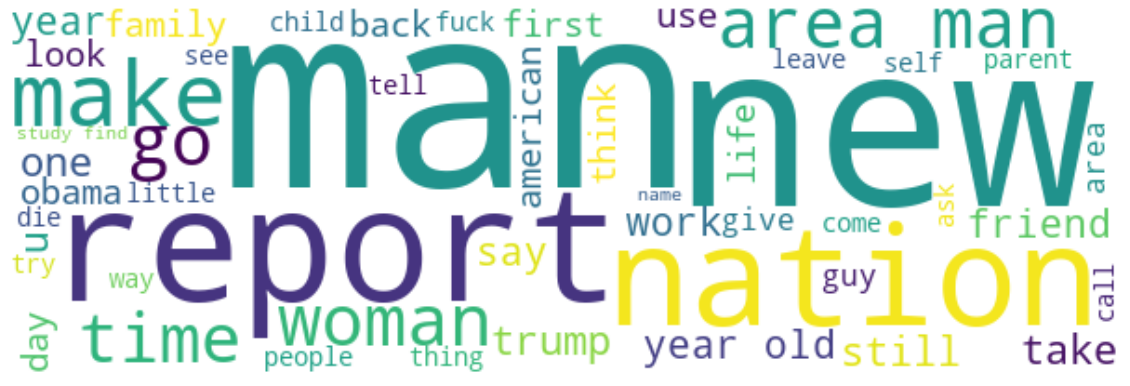

In [69]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Top 50 Words: Genuine Headlines

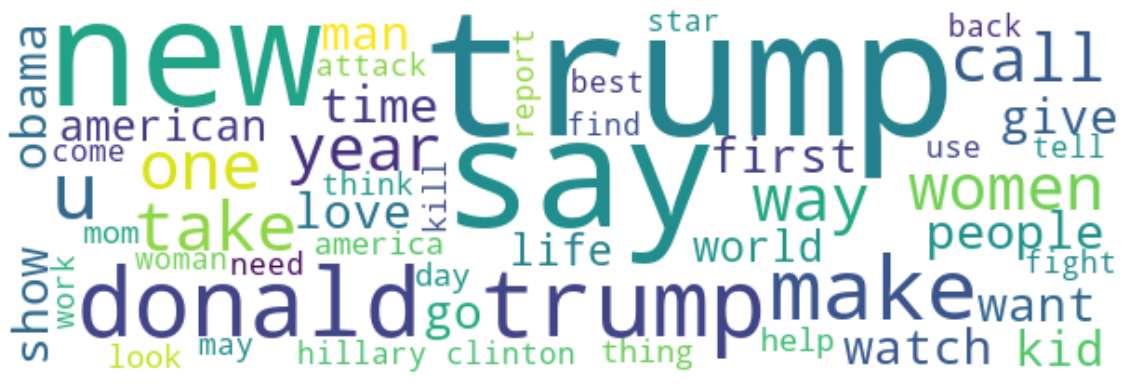

In [70]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(genuine))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model Building

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [35]:
sentences = data['clean_headline']
label = data['is_sarcastic']

## Train - Validation - Test Splitting (80:10:10)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

## Tokenization
- Splitting sentences into words
- Finding the vocab size

In [37]:
max_len = 20       
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  18630


## Encoding of Inputs
- Converting the sentences to token followed by padded sequences in encoded format
- These are numeric encodings assigned to each word

In [38]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Transformers: Attention is all you need
- For the purpose of classification problem we will only use the encoder block of the original transformers model (encoder-decoder) designed for sequence problems
- Image below is from Jay Alamar's Blog ( For detailed explanation: https://jalammar.github.io/illustrated-transformer/ )

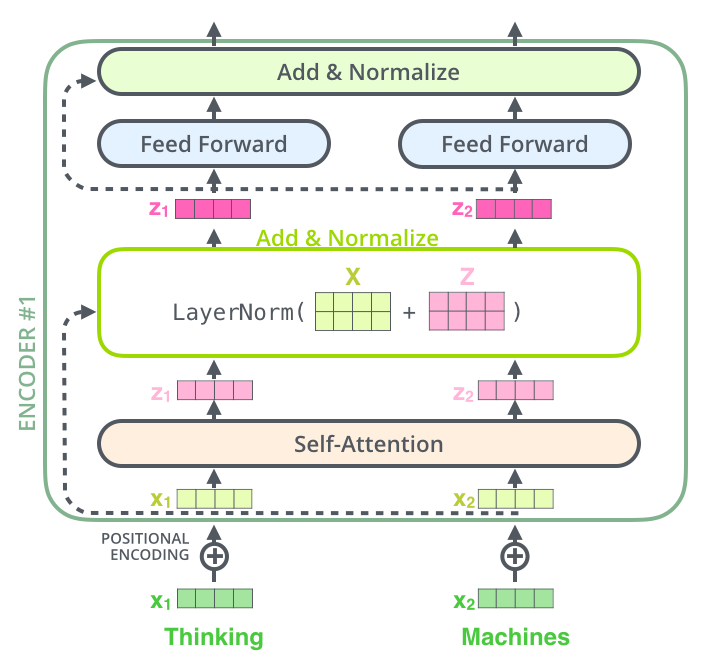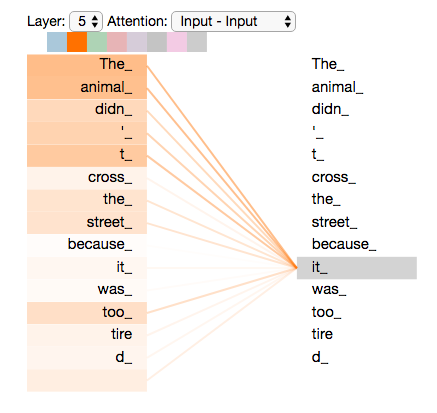

## Multi-Headed Attention
- Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension. 
- The Self Attention mechanism (illustrated in picture above next to the picture of encoder block) is used several times in parallel in Multi-Head attention
- Multiple attention heads allows for attending to parts of the sequence differently
- During self attention a word's attention score with itself will be the highest, therefore by using mutli-head attention a word can establish its relationship with other words in the sequence by calculating the attention scores with them in parallel 

In [39]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Model Definition

In [40]:
embed_dim = 50  
heads = 2  
neurons = 32
maxlen = 20
vocab_size = 20886

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 50)           1045300   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_encoder (Transf  (None, 20, 50)           23832     
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

## Model Training

In [42]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [44]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
668/668 [==============================] - 6s 10ms/step - loss: 0.1677 - accuracy: 0.9384 - val_loss: 0.5956 - val_accuracy: 0.7851
Epoch 2/25
668/668 [==============================] - 7s 10ms/step - loss: 0.1153 - accuracy: 0.9612 - val_loss: 0.7748 - val_accuracy: 0.7855
Epoch 2: early stopping


In [60]:
pd.Series(np.reshape(model.predict(X_val), (1, -1))[0]).to_frame()

84/84 [==============================] - 0s 2ms/step


0
0     0.999418
1     0.000813
2     0.969808
3     0.007124
4     0.001055
...        ...
2666  0.998927
2667  0.295234
2668  0.360318
2669  0.000556
2670  0.976510

[2671 rows x 1 columns]

# Model Evaluation

## Learning Curves
- Loss Curve
- Accuracy Curve

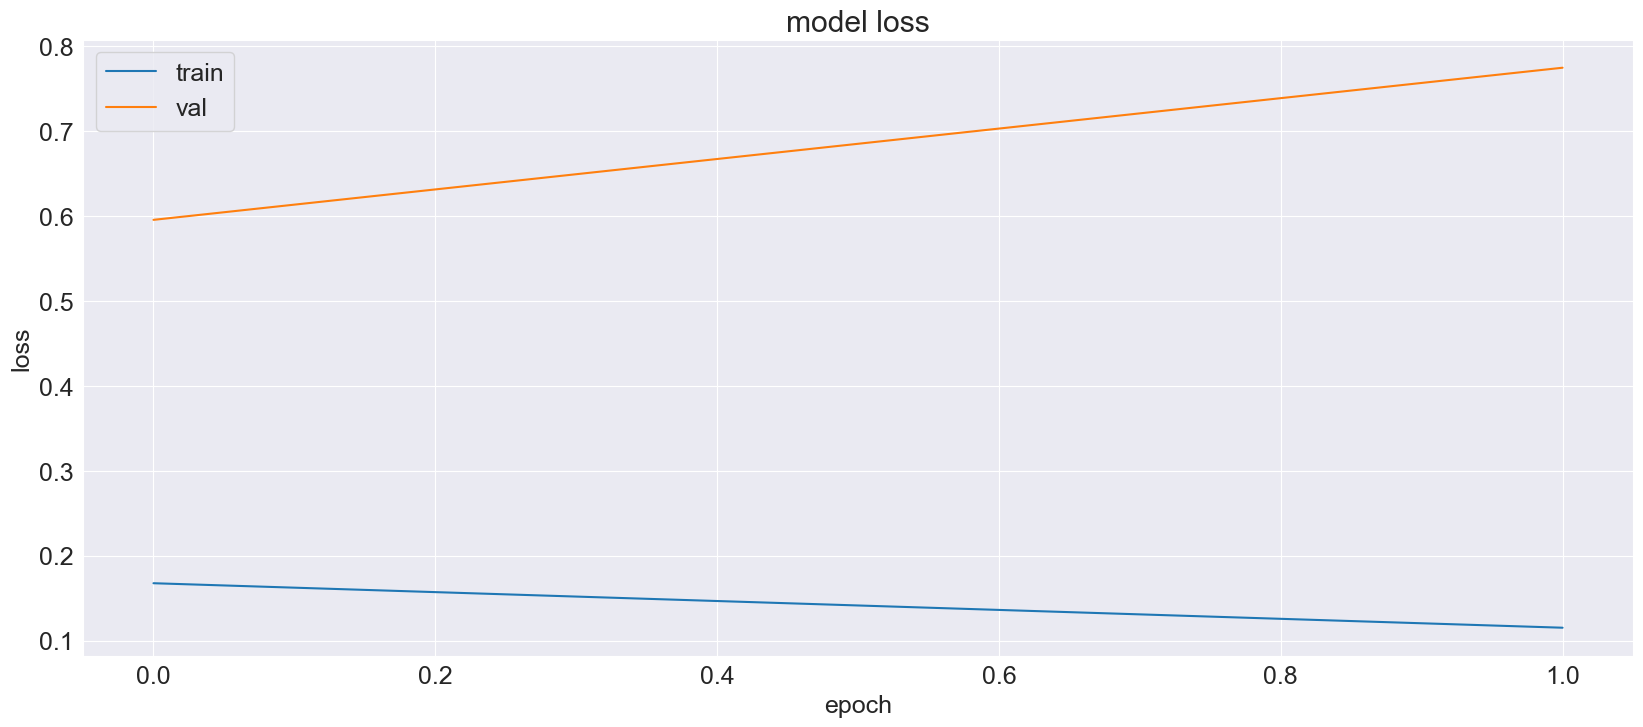

In [45]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

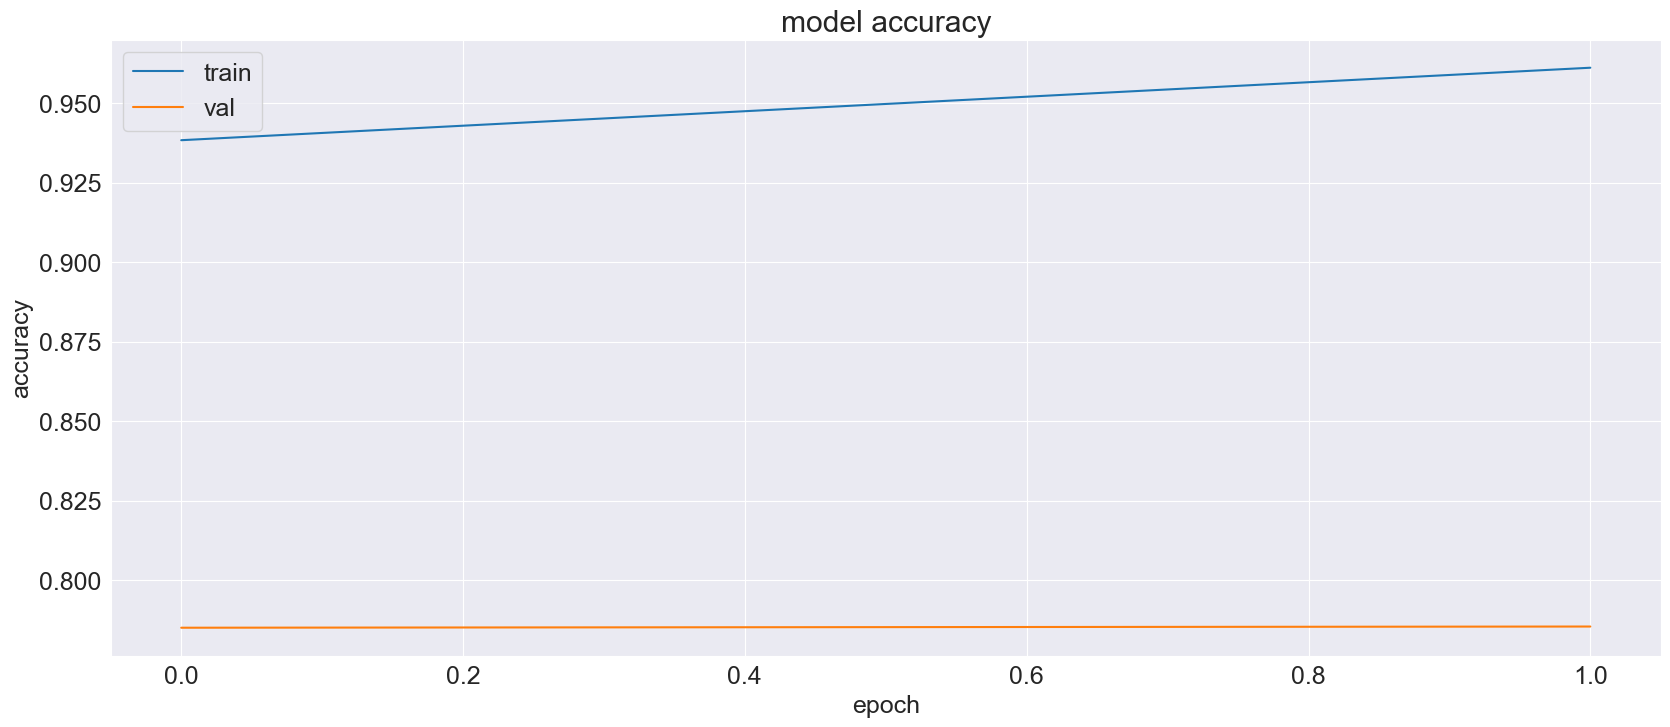

In [46]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Inference:** In case of overfitting use the traditional methods
- Low learning rate
- L1-L2 Regularization
- Dropout
- Lesser Neurons in MLP layers
- Early Stopping
- etc.

## Classification Metrics
- Since it is important to not misclassify the genuine headlines as sarcastic headlines we will also look at the roc auc score to avoid misclassification of genuine headlines as sarcastic headlines

In [84]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

### ROC Curve

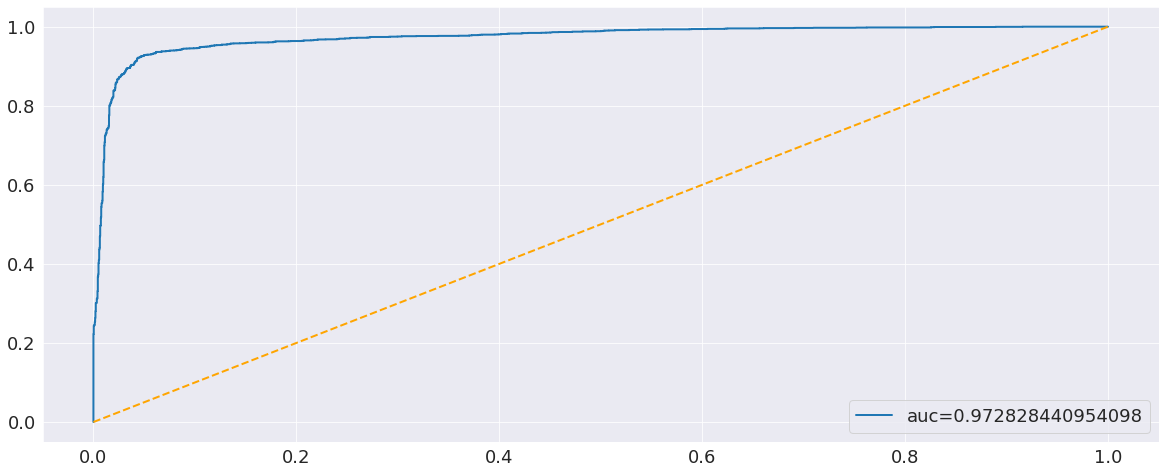

In [88]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

### Scores: Test Set Result

In [89]:
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2997
           1       0.96      0.88      0.92      2536

    accuracy                           0.93      5533
   macro avg       0.93      0.93      0.93      5533
weighted avg       0.93      0.93      0.93      5533



### Confusion Matrix

<AxesSubplot:>

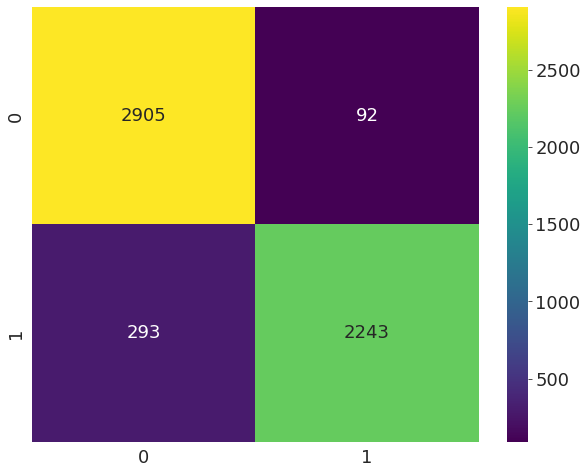

In [90]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')